# Boxing competititon (binary classification)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from catboost import CatBoostClassifier, cv, Pool
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split as split
warnings.filterwarnings(action='once')
from sklearn import preprocessing
import lightgbm

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We have to solve a binary classification problen (if a fighter wins or not)

In [2]:
df = pd.read_excel('data.xlsx', header=0)

In [116]:
df.head()

,Number,Date,fight_id,fighter_id,feature0,feature1,feature2,feature3,Wins,Losses,...,feature44,feature45,feature46,feature47,feature48,Winner Result,Month,Year,Day,day_of_week
0,1,2007-06-14,59289,19260,2557,1,1,25,8,1,...,0.3333,108.6667,36.0000,2.0000,2.6667,1,6,2007,14,3
1,2,2007-06-14,59289,19398,3520,0,0,38,8,3,...,NaN,NaN,NaN,NaN,NaN,0,6,2007,14,3
2,3,2007-06-14,59291,7742,3360,1,2,28,12,4,...,0.3333,174.3333,70.1667,0.1667,0.6667,0,6,2007,14,3
3,4,2007-06-14,59291,11285,11029,3,2,26,20,6,...,0.0000,17.4000,29.4000,6.4000,9.6000,1,6,2007,14,3
4,5,2007-06-14,59292,14615,14148,1,1,25,21,7,...,0.0000,103.0000,36.7500,5.8667,10.8667,0,6,2007,14,3


Let's split date on year and month

In [3]:
df['Date'] = df['Date'].apply(pd.to_datetime)
df['Month'], df['Year'], df['Day'], df['day_of_week'] = df['Date'].dt.month, df['Date'].dt.year, df['Date'].dt.day, df['Date'].dt.dayofweek
data = df.apply(lambda x: x.fillna('NaN') if x.dtype.kind == 'object' else x.fillna(0))
result = data['Winner Result']
data.drop(['Number', 'Date', 'Winner Result', 'fight_id'], axis=1, inplace=True)
le = preprocessing.LabelEncoder()
data['Stance'] = le.fit_transform(data['Stance'].astype(str))

Let's use one-hot encoding for features which seem to be categorical (we will check how to treat these features later)

one_hot1 = pd.get_dummies(data['Stance'])
one_hot2 = pd.get_dummies(data['Weight Class'])
data_enc = data.drop(['Weight Class', 'Stance'], axis=1)
data_enc = data_enc.join([one_hot1, one_hot2])

## Feature selection

Let's use LGBMClassifier model for further feature selection

In [57]:
%%time
features = [
            'fighter_id', 'Wins', 'Losses', 'Draws',
            'Weight Class', 'Stance', 'Odds', 'Opening odds',
            'Month', 'Year', 'Day', 'day_of_week',
            'feature0', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature6.1',
            'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
            'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
            'feature17', 'feature18', 'feature19', 'feature20',
            'feature21', 'feature22', 'feature23', 'feature24', 'feature25',
            'feature26', 'feature27', 'feature28', 'feature29', 'feature30',
            'feature31', 'feature32', 'feature33', 'feature34', 'feature35',
            'feature36', 'feature37', 'feature38', 'feature39', 'feature40',
            'feature41', 'feature42', 'feature43', 'feature44', 'feature45',
            'feature46', 'feature47', 'feature48'
           ]

X_train, X_test, y_train, y_test = split(data[features], result, test_size=0.2, shuffle=True, random_state=42)

lgb = LGBMClassifier(boosting_type='gbdt',
                     num_leaves=11,
                     max_depth=4,
                     learning_rate=0.1,
                     n_estimators=1000,
                     subsample_for_bin=20000,
                     objective=None,
                     class_weight=None,
                     min_split_gain=0.0,
                     min_child_weight=0.001,
                     min_child_samples=20,
                     subsample=.75,
                     subsample_freq=1,
                     colsample_bytree=1.0,
                     reg_alpha=0.0,
                     reg_lambda=0.0,
                     random_state=0,
                     n_jobs=-1,
                     silent=True,
                     feature_fraction=.75,
                     begging_fraction=.75,
                     begging_freq=1,
                     early_stopping_round=100)

lgb.fit(X_train, y_train,
        sample_weight=None,
        init_score=None,
        eval_set=(X_test, y_test),
        eval_names=None,
        eval_sample_weight=None,
        eval_class_weight=None,
        eval_init_score=None,
        eval_metric='logloss',
        early_stopping_rounds=None,
        verbose=True,
        feature_name=features,
        categorical_feature=[4, 5],
        callbacks=None)

print(accuracy_score(y_train, lgb.predict(X_train)), accuracy_score(y_test, lgb.predict(X_test)))


C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [4, 5]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.680481
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.668491
[3]	valid_0's binary_logloss: 0.659043
[4]	valid_0's binary_logloss: 0.658685
[5]	valid_0's binary_logloss: 0.652195
[6]	valid_0's binary_logloss: 0.645606
[7]	valid_0's binary_logloss: 0.640261
[8]	valid_0's binary_logloss: 0.636509
[9]	valid_0's binary_logloss: 0.633017
[10]	valid_0's binary_logloss: 0.630517
[11]	valid_0's binary_logloss: 0.629885
[12]	valid_0's binary_logloss: 0.627898
[13]	valid_0's binary_logloss: 0.625715
[14]	valid_0's binary_logloss: 0.623973
[15]	valid_0's binary_logloss: 0.622564
[16]	valid_0's binary_logloss: 0.621533
[17]	valid_0's binary_logloss: 0.621167
[18]	valid_0's binary_logloss: 0.620793
[19]	valid_0's binary_logloss: 0.619973
[20]	valid_0's binary_logloss: 0.619708
[21]	valid_0's binary_logloss: 0.619244
[22]	valid_0's binary_logloss: 0.619714
[23]	valid_0's binary_logloss: 0.619158
[24]	valid_0's binary_logl

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [58]:
%%time
features_to_add = data.drop([ 'fighter_id', 'Wins', 'Losses', 'Draws',
            'Weight Class', 'Stance', 'Odds'], axis=1).columns

data_test = data[['fighter_id', 'Wins', 'Losses', 'Draws',
'Weight Class', 'Stance', 'Odds']]
features_results = []
lgb = LGBMClassifier(boosting_type='gbdt',
                     num_leaves=11,
                     max_depth=4,
                     learning_rate=0.1,
                     n_estimators=1000,
                     subsample_for_bin=20000)
for feature in features_to_add:
    features_results.append(np.mean(cross_val_score(lgb, data_test, result, cv=5, n_jobs=2)))
    data_test[feature] = data[feature]

C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Aqice\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Wall time: 8min 28s


Text(0.5,1,'Comparing different features in model')

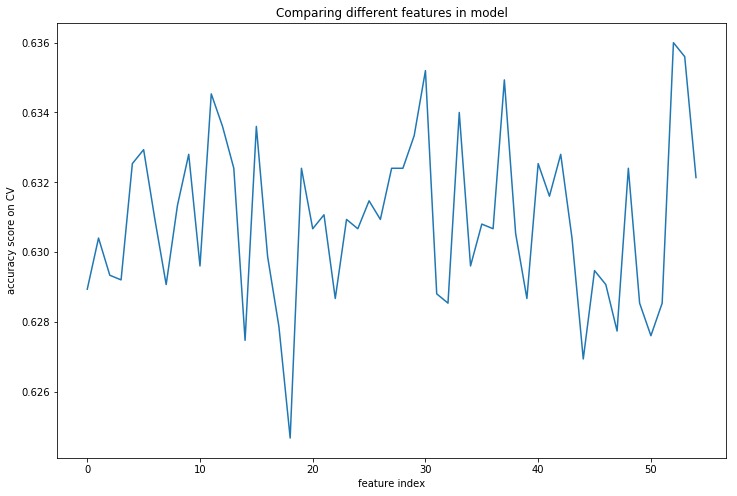

In [59]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(len(features_results)), features_results)
ax.set_xlabel('feature index')
ax.set_ylabel('accuracy score on CV')
ax.set_title('Comparing different features in model')

that there's some difference with features. Let's try to select the best features

For tuning different features we can use models like random grid CV. Let's split our data on 2 parts to check the difference further

Let's use greedy algorithm for tuning features

1) Estimate features by its impact on model with static features

2) Sort features by it's impact

3) Add features to model by sorted list order

4) Analyse results on graph

5) Compare results with full-featured model

In [65]:
train_features

Index(['feature0', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5',
       'feature6', 'Opening odds', 'feature6.1', 'feature7', 'feature8',
       'feature9', 'feature10', 'feature11', 'feature12', 'feature13',
       'feature14', 'feature15', 'feature16', 'feature17', 'feature18',
       'feature19', 'feature20', 'feature21', 'feature22', 'feature23',
       'feature24', 'feature25', 'feature26', 'feature27', 'feature28',
       'feature29', 'feature30', 'feature31', 'feature32', 'feature33',
       'feature34', 'feature35', 'feature36', 'feature37', 'feature38',
       'feature39', 'feature40', 'feature41', 'feature42', 'feature43',
       'feature44', 'feature45', 'feature46', 'feature47', 'feature48',
       'Month', 'Year', 'Day', 'day_of_week'],
      dtype='object')

In [66]:
feature_diffs = []
train_features = list(features_to_add)
for i in range(1, len(features_results)):
    feature_diffs.append(features_results[i] - features_results[i-1])
    print(features_results[i] - features_results[i-1])
    print('{} - {}'.format(train_features[i], train_features[i-1]))
    print('{} - {}'.format(features_results[i], features_results[i-1]))
    print()
#We need to delete train_feature[0] ('feature1')
train_features.pop(0)
diff_feat_dict = dict(zip(feature_diffs, train_features))

0.0014666666666667272
feature1 - feature0
0.6304000000000001 - 0.6289333333333333

-0.0010666666666667712
feature2 - feature1
0.6293333333333333 - 0.6304000000000001

-0.00013333333333331865
feature3 - feature2
0.6292 - 0.6293333333333333

0.0033333333333332993
feature4 - feature3
0.6325333333333333 - 0.6292

0.00040000000000006697
feature5 - feature4
0.6329333333333333 - 0.6325333333333333

-0.0020000000000000018
feature6 - feature5
0.6309333333333333 - 0.6329333333333333

-0.0018666666666666831
Opening odds - feature6
0.6290666666666667 - 0.6309333333333333

0.002266666666666639
feature6.1 - Opening odds
0.6313333333333333 - 0.6290666666666667

0.0014666666666666162
feature7 - feature6.1
0.6327999999999999 - 0.6313333333333333

-0.0031999999999997586
feature8 - feature7
0.6296000000000002 - 0.6327999999999999

0.004933333333333123
feature9 - feature8
0.6345333333333333 - 0.6296000000000002

-0.0009333333333333416
feature10 - feature9
0.6335999999999999 - 0.6345333333333333

-0.001199

In [67]:
print(len(train_features), len(feature_diffs))

54 54


In [68]:
from collections import OrderedDict
diff_feat_dict = OrderedDict(sorted(diff_feat_dict.items(), key=lambda t: t[0], reverse=True))

In [69]:
diff_feat_dict

OrderedDict([(0.007733333333333481, 'feature17'),
             (0.0074666666666668435, 'Year'),
             (0.006133333333333435, 'feature13'),
             (0.005466666666666842, 'feature31'),
             (0.004933333333333123, 'feature9'),
             (0.004666666666666708, 'feature46'),
             (0.004266666666666641, 'feature35'),
             (0.003866666666666685, 'feature38'),
             (0.0033333333333332993, 'feature4'),
             (0.0025333333333332764, 'feature43'),
             (0.00226666666666675, 'feature21'),
             (0.002266666666666639, 'feature6.1'),
             (0.0018666666666666831, 'feature28'),
             (0.0014666666666667272, 'feature25'),
             (0.0014666666666666162, 'feature7'),
             (0.0012000000000000899, 'feature33'),
             (0.0011999999999999789, 'feature40'),
             (0.0009333333333332305, 'Month'),
             (0.0008000000000000229, 'feature23'),
             (0.00040000000000006697, 'feature19'),


In [70]:
%%time
X_train_t = X_train.drop(train_features, axis=1)
features_results3 = []
dict_to_work = diff_feat_dict.copy()
feature_names = []
data_with_static_features = X_train.drop(train_features, axis=1)
to_break = False
for e in range(10):
    if e == 0:
        value_on_step = list(dict_to_work.keys())[0]
        X_train_t[dict_to_work[value_on_step]] = X_train[dict_to_work[value_on_step]]
        feature_names.append(dict_to_work[value_on_step])
        print(dict_to_work[value_on_step], 'popped')
        dict_to_work.pop(value_on_step)
        features_results3.append(np.mean(cross_val_score(lgb, X_train_t, y_train, cv=5, n_jobs=2)))
    if to_break:
        X_train_t.drop(feature_names.pop(), axis=1, inplace=True)
        features_results3.pop()
        break
    else:
        data = X_train_t.copy()
        acc_on_step = 0
        value_on_step = 0
        i = 0
        while acc_on_step <= features_results3[e]:
            if i >= len(dict_to_work):
                to_break = True
                break
            value_on_step = list(dict_to_work.keys())[i]
            data[dict_to_work[value_on_step]] = X_train[diff_feat_dict[value_on_step]]
            acc_on_step = np.mean(cross_val_score(lgb, data, y_train, cv=5, n_jobs=2))
            print(i, acc_on_step, dict_to_work[value_on_step], len(dict_to_work))
            i += 1
        features_results3.append(acc_on_step)
        X_train_t[dict_to_work[value_on_step]] = X_train[dict_to_work[value_on_step]]
        feature_names.append(dict_to_work[value_on_step])
        print(dict_to_work[value_on_step], 'popped')
        dict_to_work.pop(value_on_step)
    

feature17 popped
0 0.6288307291648583 Year 48
1 0.6354983716423878 feature13 48
feature13 popped
0 0.6354983716423878 Year 47
1 0.6324983695590529 feature31 47
2 0.6306654532398981 feature9 47
3 0.634000731713471 feature46 47
4 0.6326626754601913 feature35 47
5 0.634496983678461 feature38 47
6 0.6281694811362136 feature4 47
7 0.6323311508086695 feature43 47
8 0.6294997591433512 feature21 47
9 0.6286648979154383 feature6.1 47
10 0.6298329546293666 feature28 47
11 0.6298329546293666 feature25 47
12 0.6369989295131455 feature7 47
feature7 popped
0 0.6328319811333203 Year 46
1 0.6241655915501794 feature31 46
2 0.6329982307858085 feature9 46
3 0.6289967017338206 feature46 46
4 0.6276643416650521 feature35 46
5 0.6338310104150534 feature38 46
6 0.6353323999993518 feature4 46
7 0.6320008718756055 feature43 46
8 0.6349978174753362 feature21 46
9 0.6311669809029959 feature6.1 46
10 0.6369989295131455 feature28 46
11 0.6369989295131455 feature25 46
12 0.6248325336800002 feature33 46
13 0.6313296

Text(0.5,1,'Comparing different features in the model')

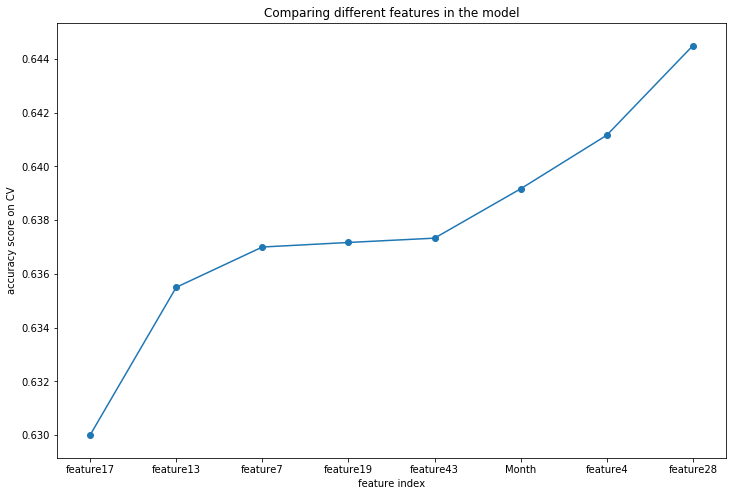

In [71]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(feature_names, features_results3)
ax.scatter(feature_names, features_results3)
ax.set_xlabel('feature index')
ax.set_ylabel('accuracy score on CV')
ax.set_title('Comparing different features in the model')

In [72]:
X_test_t = X_test[X_train_t.columns]

In [100]:
X_test_t.head()

,fighter_id,Wins,Losses,Draws,Weight Class,Stance,Odds,feature0,feature17,feature13,feature7,feature19,feature43,Month,feature4,feature28
970,8089,25,7,3,265,3,-490,16985,0.1321,0.6,1,73.0,11.9057,2,121.0,0.0755
6279,34118,20,3,0,155,3,-135,5671,0.5385,0.8,1,74.0,41.2308,8,654.0,0.0000
1859,19297,15,7,0,145,0,141,12922,0.0000,0.8,8,0.0,25.3333,9,58.0,0.6667
6803,84064,12,1,0,185,2,100,8476,2.3846,0.8,1,75.0,32.0769,2,169.0,0.0000
6305,94540,10,2,0,145,3,-150,5805,0.6250,0.8,6,73.0,27.1250,9,48.0,0.2500


In [93]:
%%time
med = []
lgb = LGBMClassifier(boosting_type='gbdt',
                     num_leaves=11,
                     max_depth=4,
                     learning_rate=0.1,
                     n_estimators=1000,
                     subsample_for_bin=20000,
                     objective=None,
                     class_weight=None,
                     min_split_gain=0.0,
                     min_child_weight=0.001,
                     min_child_samples=20,
                     subsample=.75,
                     subsample_freq=1,
                     colsample_bytree=1.0,
                     reg_alpha=0.0,
                     reg_lambda=0.0,
                     random_state=0,
                     n_jobs=-1,
                     silent=True,
                     feature_fraction=.75,
                     begging_fraction=.75,
                     begging_freq=1,
                     early_stopping_round=100)
for i in range(5):
    lgb.fit(X_train_t, y_train,
        eval_set=(X_test_t, y_test),
        eval_names=None,
        eval_sample_weight=None,
        eval_class_weight=None,
        eval_init_score=None,
        eval_metric='logloss',
        early_stopping_rounds=None,
        verbose=True,
        feature_name=list(X_test_t.columns),
        categorical_feature=[0, 4, 5, 13])
    med.append(accuracy_score(y_test, lgb.predict(X_test_t)))
print(np.mean(med))

C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 4, 5, 13]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.691231
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.677216
[3]	valid_0's binary_logloss: 0.675395
[4]	valid_0's binary_logloss: 0.664115
[5]	valid_0's binary_logloss: 0.655253
[6]	valid_0's binary_logloss: 0.655042
[7]	valid_0's binary_logloss: 0.654566
[8]	valid_0's binary_logloss: 0.648018
[9]	valid_0's binary_logloss: 0.642478
[10]	valid_0's binary_logloss: 0.638067
[11]	valid_0's binary_logloss: 0.634632
[12]	valid_0's binary_logloss: 0.631518
[13]	valid_0's binary_logloss: 0.629257
[14]	valid_0's binary_logloss: 0.627247
[15]	valid_0's binary_logloss: 0.626169
[16]	valid_0's binary_logloss: 0.624638
[17]	valid_0's binary_logloss: 0.623615
[18]	valid_0's binary_logloss: 0.62282
[19]	valid_0's binary_logloss: 0.621254
[20]	valid_0's binary_logloss: 0.621574
[21]	valid_0's binary_logloss: 0.621164
[22]	valid_0's binary_logloss: 0.621107
[23]	valid_0's binary_logloss: 0.621228
[24]	valid_0's binary_loglo

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 4, 5, 13]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[50]	valid_0's binary_logloss: 0.627073
[51]	valid_0's binary_logloss: 0.627509
[52]	valid_0's binary_logloss: 0.627378
[53]	valid_0's binary_logloss: 0.62747
[54]	valid_0's binary_logloss: 0.628227
[55]	valid_0's binary_logloss: 0.628273
[56]	valid_0's binary_logloss: 0.627965
[57]	valid_0's binary_logloss: 0.628268
[58]	valid_0's binary_logloss: 0.628821
[59]	valid_0's binary_logloss: 0.629234
[60]	valid_0's binary_logloss: 0.630174
[61]	valid_0's binary_logloss: 0.631351
[62]	valid_0's binary_logloss: 0.631441
[63]	valid_0's binary_logloss: 0.631671
[64]	valid_0's binary_logloss: 0.631527
[65]	valid_0's binary_logloss: 0.632034
[66]	valid_0's binary_logloss: 0.632141
[67]	valid_0's binary_logloss: 0.631797
[68]	valid_0's binary_logloss: 0.632413
[69]	valid_0's binary_logloss: 0.632437
[70]	valid_0's binary_logloss: 0.632728
[71]	valid_0's binary_logloss: 0.632891
[72]	valid_0's binary_logloss: 0.632725
[73]	valid_0's binary_logloss: 0.633053
[74]	valid_0's binary_logloss: 0.633235
[

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 4, 5, 13]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[3]	valid_0's binary_logloss: 0.675395
[4]	valid_0's binary_logloss: 0.664115
[5]	valid_0's binary_logloss: 0.655253
[6]	valid_0's binary_logloss: 0.655042
[7]	valid_0's binary_logloss: 0.654566
[8]	valid_0's binary_logloss: 0.648018
[9]	valid_0's binary_logloss: 0.642478
[10]	valid_0's binary_logloss: 0.638067
[11]	valid_0's binary_logloss: 0.634632
[12]	valid_0's binary_logloss: 0.631518
[13]	valid_0's binary_logloss: 0.629257
[14]	valid_0's binary_logloss: 0.627247
[15]	valid_0's binary_logloss: 0.626169
[16]	valid_0's binary_logloss: 0.624638
[17]	valid_0's binary_logloss: 0.623615
[18]	valid_0's binary_logloss: 0.62282
[19]	valid_0's binary_logloss: 0.621254
[20]	valid_0's binary_logloss: 0.621574
[21]	valid_0's binary_logloss: 0.621164
[22]	valid_0's binary_logloss: 0.621107
[23]	valid_0's binary_logloss: 0.621228
[24]	valid_0's binary_logloss: 0.620969
[25]	valid_0's binary_logloss: 0.621248
[26]	valid_0's binary_logloss: 0.62123
[27]	valid_0's binary_logloss: 0.621319
[28]	vali

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 4, 5, 13]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[83]	valid_0's binary_logloss: 0.634489
[84]	valid_0's binary_logloss: 0.634885
[85]	valid_0's binary_logloss: 0.635113
[86]	valid_0's binary_logloss: 0.635059
[87]	valid_0's binary_logloss: 0.634093
[88]	valid_0's binary_logloss: 0.633607
[89]	valid_0's binary_logloss: 0.633027
[90]	valid_0's binary_logloss: 0.63332
[91]	valid_0's binary_logloss: 0.632818
[92]	valid_0's binary_logloss: 0.633412
[93]	valid_0's binary_logloss: 0.63374
[94]	valid_0's binary_logloss: 0.634376
[95]	valid_0's binary_logloss: 0.634358
[96]	valid_0's binary_logloss: 0.634778
[97]	valid_0's binary_logloss: 0.635194
[98]	valid_0's binary_logloss: 0.635371
[99]	valid_0's binary_logloss: 0.635342
[100]	valid_0's binary_logloss: 0.635242
[101]	valid_0's binary_logloss: 0.63516
[102]	valid_0's binary_logloss: 0.635031
[103]	valid_0's binary_logloss: 0.635077
[104]	valid_0's binary_logloss: 0.635826
[105]	valid_0's binary_logloss: 0.636218
[106]	valid_0's binary_logloss: 0.635951
[107]	valid_0's binary_logloss: 0.63

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 4, 5, 13]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[25]	valid_0's binary_logloss: 0.621248
[26]	valid_0's binary_logloss: 0.62123
[27]	valid_0's binary_logloss: 0.621319
[28]	valid_0's binary_logloss: 0.621304
[29]	valid_0's binary_logloss: 0.621609
[30]	valid_0's binary_logloss: 0.621478
[31]	valid_0's binary_logloss: 0.621583
[32]	valid_0's binary_logloss: 0.621389
[33]	valid_0's binary_logloss: 0.621275
[34]	valid_0's binary_logloss: 0.621267
[35]	valid_0's binary_logloss: 0.621331
[36]	valid_0's binary_logloss: 0.621989
[37]	valid_0's binary_logloss: 0.622158
[38]	valid_0's binary_logloss: 0.621926
[39]	valid_0's binary_logloss: 0.622192
[40]	valid_0's binary_logloss: 0.622331
[41]	valid_0's binary_logloss: 0.6227
[42]	valid_0's binary_logloss: 0.623043
[43]	valid_0's binary_logloss: 0.62326
[44]	valid_0's binary_logloss: 0.623793
[45]	valid_0's binary_logloss: 0.625039
[46]	valid_0's binary_logloss: 0.625517
[47]	valid_0's binary_logloss: 0.625215
[48]	valid_0's binary_logloss: 0.62596
[49]	valid_0's binary_logloss: 0.626872
[50]	

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [94]:
X_train.head()

,fighter_id,Wins,Losses,Draws,Weight Class,Stance,Odds,Opening odds,Month,Year,...,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48
4664,10821,24,3,0,155,2,265,162,12,2014,...,0.7667,11.1667,39.5667,1.9500,42.6000,0.1000,216.0244,17.8056,5.2833,7.9167
4411,41876,17,6,0,185,2,225,235,9,2014,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7448,25103,21,6,0,170,2,-129,-106,11,2017,...,0.0000,10.6667,36.6667,2.0000,38.6667,0.0000,251.3333,39.3333,0.0000,0.0000
1919,5181,10,2,0,170,2,-388,-253,10,2011,...,0.2778,4.6111,11.8333,2.3889,14.6667,0.1667,83.6667,132.3125,3.2778,5.1667
1298,15727,23,6,0,145,2,187,222,9,2010,...,0.5000,3.6667,17.6667,2.3333,20.7500,0.0833,80.5000,25.4167,3.1667,5.0833


In [98]:
%%time
med2 = []
for i in range(5):
    lgb.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        eval_names=None,
        eval_sample_weight=None,
        eval_class_weight=None,
        eval_init_score=None,
        eval_metric='logloss',
        early_stopping_rounds=None,
        verbose=True,
        feature_name=list(X_test.columns),
        categorical_feature=[0, 4, 5])
    med2.append(accuracy_score(np.array(y_test), lgb.predict(X_test)))
print(np.mean(med2))

C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 4, 5]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.680242
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.668175
[3]	valid_0's binary_logloss: 0.658462
[4]	valid_0's binary_logloss: 0.657182
[5]	valid_0's binary_logloss: 0.650716
[6]	valid_0's binary_logloss: 0.644478
[7]	valid_0's binary_logloss: 0.6392
[8]	valid_0's binary_logloss: 0.635909
[9]	valid_0's binary_logloss: 0.632495
[10]	valid_0's binary_logloss: 0.629398
[11]	valid_0's binary_logloss: 0.629507
[12]	valid_0's binary_logloss: 0.627098
[13]	valid_0's binary_logloss: 0.625238
[14]	valid_0's binary_logloss: 0.623452
[15]	valid_0's binary_logloss: 0.622158
[16]	valid_0's binary_logloss: 0.620418
[17]	valid_0's binary_logloss: 0.620069
[18]	valid_0's binary_logloss: 0.619746
[19]	valid_0's binary_logloss: 0.619535
[20]	valid_0's binary_logloss: 0.619266
[21]	valid_0's binary_logloss: 0.619254
[22]	valid_0's binary_logloss: 0.619886
[23]	valid_0's binary_logloss: 0.619825
[24]	valid_0's binary_loglos

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 4, 5]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[2]	valid_0's binary_logloss: 0.668175
[3]	valid_0's binary_logloss: 0.658462
[4]	valid_0's binary_logloss: 0.657182
[5]	valid_0's binary_logloss: 0.650716
[6]	valid_0's binary_logloss: 0.644478
[7]	valid_0's binary_logloss: 0.6392
[8]	valid_0's binary_logloss: 0.635909
[9]	valid_0's binary_logloss: 0.632495
[10]	valid_0's binary_logloss: 0.629398
[11]	valid_0's binary_logloss: 0.629507
[12]	valid_0's binary_logloss: 0.627098
[13]	valid_0's binary_logloss: 0.625238
[14]	valid_0's binary_logloss: 0.623452
[15]	valid_0's binary_logloss: 0.622158
[16]	valid_0's binary_logloss: 0.620418
[17]	valid_0's binary_logloss: 0.620069
[18]	valid_0's binary_logloss: 0.619746
[19]	valid_0's binary_logloss: 0.619535
[20]	valid_0's binary_logloss: 0.619266
[21]	valid_0's binary_logloss: 0.619254
[22]	valid_0's binary_logloss: 0.619886
[23]	valid_0's binary_logloss: 0.619825
[24]	valid_0's binary_logloss: 0.619732
[25]	valid_0's binary_logloss: 0.619701
[26]	valid_0's binary_logloss: 0.620022
[27]	valid

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 4, 5]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[14]	valid_0's binary_logloss: 0.623452
[15]	valid_0's binary_logloss: 0.622158
[16]	valid_0's binary_logloss: 0.620418
[17]	valid_0's binary_logloss: 0.620069
[18]	valid_0's binary_logloss: 0.619746
[19]	valid_0's binary_logloss: 0.619535
[20]	valid_0's binary_logloss: 0.619266
[21]	valid_0's binary_logloss: 0.619254
[22]	valid_0's binary_logloss: 0.619886
[23]	valid_0's binary_logloss: 0.619825
[24]	valid_0's binary_logloss: 0.619732
[25]	valid_0's binary_logloss: 0.619701
[26]	valid_0's binary_logloss: 0.620022
[27]	valid_0's binary_logloss: 0.620072
[28]	valid_0's binary_logloss: 0.619997
[29]	valid_0's binary_logloss: 0.61938
[30]	valid_0's binary_logloss: 0.619891
[31]	valid_0's binary_logloss: 0.619897
[32]	valid_0's binary_logloss: 0.619616
[33]	valid_0's binary_logloss: 0.620097
[34]	valid_0's binary_logloss: 0.620235
[35]	valid_0's binary_logloss: 0.620751
[36]	valid_0's binary_logloss: 0.62126
[37]	valid_0's binary_logloss: 0.621647
[38]	valid_0's binary_logloss: 0.622439
[

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 4, 5]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.680242
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.668175
[3]	valid_0's binary_logloss: 0.658462
[4]	valid_0's binary_logloss: 0.657182
[5]	valid_0's binary_logloss: 0.650716
[6]	valid_0's binary_logloss: 0.644478
[7]	valid_0's binary_logloss: 0.6392
[8]	valid_0's binary_logloss: 0.635909
[9]	valid_0's binary_logloss: 0.632495
[10]	valid_0's binary_logloss: 0.629398
[11]	valid_0's binary_logloss: 0.629507
[12]	valid_0's binary_logloss: 0.627098
[13]	valid_0's binary_logloss: 0.625238
[14]	valid_0's binary_logloss: 0.623452
[15]	valid_0's binary_logloss: 0.622158
[16]	valid_0's binary_logloss: 0.620418
[17]	valid_0's binary_logloss: 0.620069
[18]	valid_0's binary_logloss: 0.619746
[19]	valid_0's binary_logloss: 0.619535
[20]	valid_0's binary_logloss: 0.619266
[21]	valid_0's binary_logloss: 0.619254
[22]	valid_0's binary_logloss: 0.619886
[23]	valid_0's binary_logloss: 0.619825
[24]	valid_0's binary_loglos

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Aqice\Anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 4, 5]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.680242
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.668175
[3]	valid_0's binary_logloss: 0.658462
[4]	valid_0's binary_logloss: 0.657182
[5]	valid_0's binary_logloss: 0.650716
[6]	valid_0's binary_logloss: 0.644478
[7]	valid_0's binary_logloss: 0.6392
[8]	valid_0's binary_logloss: 0.635909
[9]	valid_0's binary_logloss: 0.632495
[10]	valid_0's binary_logloss: 0.629398
[11]	valid_0's binary_logloss: 0.629507
[12]	valid_0's binary_logloss: 0.627098
[13]	valid_0's binary_logloss: 0.625238
[14]	valid_0's binary_logloss: 0.623452
[15]	valid_0's binary_logloss: 0.622158
[16]	valid_0's binary_logloss: 0.620418
[17]	valid_0's binary_logloss: 0.620069
[18]	valid_0's binary_logloss: 0.619746
[19]	valid_0's binary_logloss: 0.619535
[20]	valid_0's binary_logloss: 0.619266
[21]	valid_0's binary_logloss: 0.619254
[22]	valid_0's binary_logloss: 0.619886
[23]	valid_0's binary_logloss: 0.619825
[24]	valid_0's binary_loglos

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [99]:
print(np.mean(med))
print(np.mean(med2))

0.65
0.6486666666666666


As we can see, lgb model fitted with selected features works ~2-3 times faster and has better accuracy

# Categorical features vs non-categorical features

Let's find out what features better to treat as categorical using catboostclassifier model on our selected features

## CatBosstClassifier

We don't need to use GridSearchCV for CatBoost because there's a built-in option (use_best_model=True) to find the best parameters for a model

In [101]:
normal_features = list(X_test_t.columns)
for i in range(len(normal_features)):
    print(i, normal_features[i])

0 fighter_id
1 Wins
2 Losses
3 Draws
4 Weight Class
5 Stance
6 Odds
7 feature0
8 feature17
9 feature13
10 feature7
11 feature19
12 feature43
13 Month
14 feature4
15 feature28


In [102]:
data = df.dropna()
result = data['Winner Result']
data.drop(['Number', 'fight_id', 'Date', 'Winner Result'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = split(data[normal_features], result, train_size=0.75, shuffle=True, random_state=42)

C:\Users\Aqice\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [103]:
# 0 ('Stance') - is constant-categorical feature
feature_comb = [[5], [5, 0], [5, 4], [5, 0, 4]]
acc_score_cat = {}
cat = CatBoostClassifier(eval_metric='Accuracy',
                         allow_writing_files=False,
                         use_best_model=True)
for cat_index in feature_comb:
    cat.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=list(cat_index), silent=True, use_best_model=True)
    acc_score_cat[str(cat_index)] = [accuracy_score(y_test, cat.predict(X_test)), accuracy_score(y_train, cat.predict(X_train))]

Learning rate set to 0.091798
Learning rate set to 0.091798
Learning rate set to 0.091798
Learning rate set to 0.091798


[5]:
test accuracy: 0.6575255102040817
train accuracy: 0.7198468410976387

[5, 0]:
test accuracy: 0.71875
train accuracy: 0.8596043395022336

[5, 4]:
test accuracy: 0.6594387755102041
train accuracy: 0.706019995745586

[5, 0, 4]:
test accuracy: 0.7021683673469388
train accuracy: 0.8136566687938737



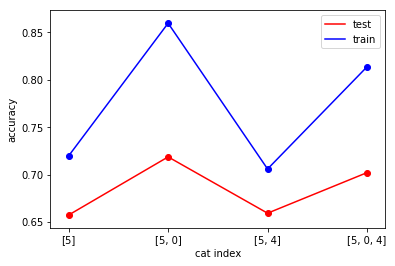

In [111]:
for values, key in zip(acc_score_cat.values(), acc_score_cat.keys()):
    print('{}:'.format(key))
    print('test accuracy: {}'.format(values[0]))
    print('train accuracy: {}'.format(values[1]))
    print()
plt.xlabel('cat index')
plt.ylabel('accuracy')
plt.plot(list(acc_score_cat.keys()), np.array(list(acc_score_cat.values()))[:, 0], color='red', label='test')
plt.plot(list(acc_score_cat.keys()), np.array(list(acc_score_cat.values()))[:, 1], color='blue', label='train')
plt.scatter(list(acc_score_cat.keys()), np.array(list(acc_score_cat.values()))[:, 0], color='red')
plt.scatter(list(acc_score_cat.keys()), np.array(list(acc_score_cat.values()))[:, 1], color='blue')
plt.legend()
plt.show()

In [109]:
%%time
cat.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=[0, 5], silent=True, use_best_model=True)

Learning rate set to 0.091798
Wall time: 33.8 s


In [112]:
print(cat.get_params())
cat_train_acc = accuracy_score(y_train, cat.predict(X_train))
cat_test_acc = accuracy_score(y_test, cat.predict(X_test))
print('cat (train): {}'.format(cat_train_acc))
print('cat (test): {}'.format(cat_test_acc))

{'allow_writing_files': False, 'eval_metric': 'Accuracy', 'use_best_model': True, 'loss_function': 'Logloss'}
cat (train): 0.8391831525207403
cat (test): 0.7295918367346939


## Logistic regression

For logistic regression model we need to use one-hot encoding for categorical features

In [113]:
one_hot1 = pd.get_dummies(data['Stance'])
one_hot2 = pd.get_dummies(data['fighter_id'])
data_enc = data[normal_features].drop(['Weight Class', 'Stance'], axis=1)
data_enc = data_enc.join([one_hot1, one_hot2])
X_train_enc, X_test_enc, y_train, y_test = split(data_enc, result, train_size=0.75, shuffle=True, random_state=42)

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Let's try out logistic regression with parameters' tuning with GridSearchCV

In [114]:
%%time
lgGridParams = {
    'penalty' : ['l1', 'l2'],
    'C' : list(np.linspace(0.1, 2, 20)),
    }
lg = LogisticRegression()
lg_clf = GridSearchCV(lg, lgGridParams, cv=3)
lg_best_model = lg_clf.fit(X_train_enc, y_train)

Wall time: 22.8 s


In [115]:
print(lg_best_model.best_estimator_.get_params())
lg_train_acc = accuracy_score(y_train, lg_best_model.predict(X_train_enc))
lg_test_acc = accuracy_score(y_test, lg_best_model.predict(X_test_enc))
print('lg (train): {}'.format(lg_train_acc))
print('lg (test): {}'.format(lg_test_acc))

{'C': 0.8999999999999999, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
lg (train): 0.6604977664326739
lg (test): 0.6441326530612245


## Lightgbm

There are many parameters to tune in Lightgbm. Let's use RandomizedSearchCV to make the tuning faster 

In [121]:
lgbGridParams = {
    'learning_rate': np.arange(0.001, 0.1, 0.005),
    'n_estimators': list(range(100,1000, 20)),
    'num_leaves': list(range(2,50, 1)),
    'max_depth': list(range(2,10)),
    'reg_alpha': np.arange(0, 3, 0.2),
    'reg_lambda': np.arange(0, 1, 0.1)
    }
lgb = LGBMClassifier(boosting_type='gbdt',
                     learning_rate=0.1,
                     subsample_for_bin=20000,
                     objective=None,
                     class_weight=None,
                     min_split_gain=0.0,
                     min_child_weight=0.001,
                     min_child_samples=20,
                     subsample=.75,
                     subsample_freq=1,
                     colsample_bytree=1.0,
                     reg_alpha=0.0,
                     reg_lambda=0.0,
                     random_state=0,
                     n_jobs=-1,
                     silent=True,
                     feature_fraction=.75,
                     begging_fraction=.75,
                     begging_freq=1,
                     early_stopping_round=100)

lgb_clf_random = RandomizedSearchCV(lgb, lgbGridParams, n_iter=2000)
# let's encode Stance and fighter_id for RandomizedSearchCV fitting
stance = {'open stance': 1, 'orthodox': 2, 'southpaw': 3, 'switch': 4} 
X_train_num_cat, X_test_num_cat = X_train.copy(), X_test.copy()
X_train_num_cat['Stance'] = [stance[item] for item in X_train_num_cat['Stance']]
X_train_num_cat['fighter_id'] = pd.to_numeric(X_train_num_cat['fighter_id'])
X_test_num_cat['Stance'] = [stance[item] for item in X_test_num_cat['Stance']]
X_test_num_cat['fighter_id'] = pd.to_numeric(X_test_num_cat['fighter_id'])

In [ ]:
lgb_best_model = lgb_clf_random.fit(X_train_num_cat, y_train,
                    eval_set=(X_test_num_cat, y_test),
                    eval_names=None,
                    eval_sample_weight=None,
                    eval_class_weight=None,
                    eval_init_score=None,
                    eval_metric='logloss',
                    early_stopping_rounds=None,
                    verbose=True,
                    feature_name=list(X_test_num_cat.columns))

In [123]:
print(lgb_best_model.best_estimator_.get_params())
lgb_train_acc = accuracy_score(y_train, lgb_best_model.predict(X_train_num_cat))
lgb_test_acc = accuracy_score(y_test, lgb_best_model.predict(X_test_num_cat))
print('lgb (train): {}'.format(lgb_train_acc))
print('lgb (test): {}'.format(lgb_test_acc))

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'learning_rate': 0.091, 'max_depth': 4, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 540, 'n_jobs': -1, 'num_leaves': 18, 'objective': None, 'random_state': 0, 'reg_alpha': 2.8000000000000003, 'reg_lambda': 0.5, 'silent': True, 'subsample': 0.75, 'subsample_for_bin': 20000, 'subsample_freq': 1, 'feature_fraction': 0.75, 'begging_fraction': 0.75, 'begging_freq': 1, 'early_stopping_round': 100}
lgb (train): 0.7058072750478621
lgb (test): 0.6441326530612245


C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Let's look at final results of each classifier

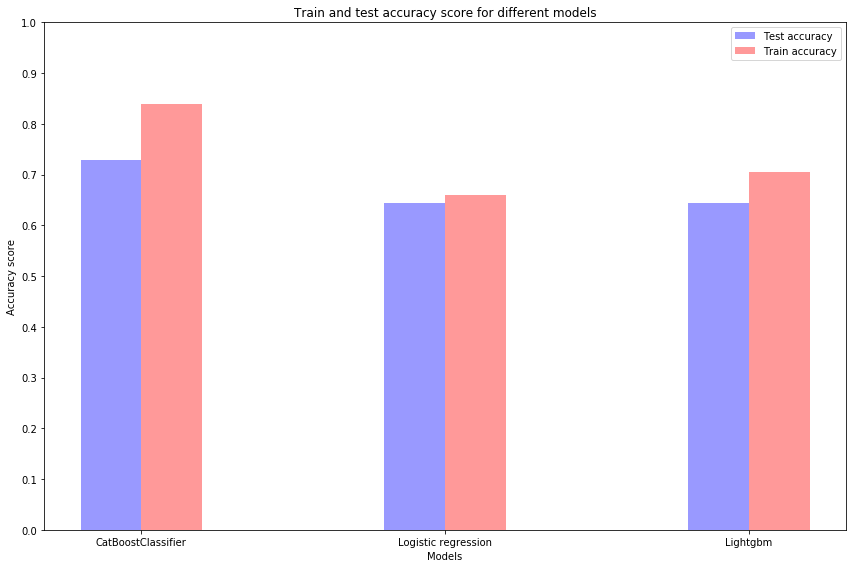

In [124]:
test_acc = (cat_test_acc, lg_test_acc, lgb_test_acc)
train_acc = (cat_train_acc, lg_train_acc, lgb_train_acc)
fig, ax = plt.subplots(figsize=(12, 8))
index = np.arange(3)
bar_width = 0.2
opacity = 0.4
error_config = {'ecolor': '0.4'}

rects1 = ax.bar(index, test_acc, bar_width, alpha=opacity, color='b', error_kw=error_config, label='Test accuracy')
rects2 = ax.bar(index + bar_width, train_acc, bar_width, alpha=opacity, color='r', error_kw=error_config, label='Train accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy score')
ax.set_title('Train and test accuracy score for different models')
ax.set_xticks(index + bar_width / 2)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels(('CatBoostClassifier', 'Logistic regression', 'Lightgbm'))
ax.legend()

fig.tight_layout()
plt.show()

In [125]:
print('lg and lgb answers simularity: {}'.format(
    accuracy_score(lg_best_model.predict(X_test_enc), lgb_best_model.predict(X_test_num_cat))
    ))
print('lg and cat answers simularity: {}'.format(
    accuracy_score(lg_best_model.predict(X_test_enc), cat.predict(X_test))
    ))
print('lgb and cat answers simularity: {}'.format(
    accuracy_score(lgb_best_model.predict(X_test_num_cat), cat.predict(X_test))
    ))

lg and lgb answers simularity: 0.8788265306122449
lg and cat answers simularity: 0.764030612244898
lgb and cat answers simularity: 0.7971938775510204


C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Ensembling

In [131]:
def alg_ensemble(pred_list, y):
    #pred_list.shape[1] should be 3
    result = {}
    A, B, C = np.arange(0.8, 2, 0.1), np.arange(0.2, 1, 0.05), np.arange(0.2, 1, 0.05)
    for a in A:
        for b in B:
            for c in C:
                ans = np.zeros(len(y))
                for i in range(len(ans)):
                    ans[i] = (a * pred_list[i, 0] + b * pred_list[i, 1] + c * pred_list[i, 2]) / 3
                    ans[i] = 1 if ans[i] >= 0.5 else 0
                result[str([a,b,c])] = accuracy_score(y, ans)
        print(a)
    return result
        

In [127]:
preds_test = []
preds_train = []
preds_test.append(cat.predict(X_test))
preds_train.append(cat.predict(X_train))
preds_test.append(lg_best_model.predict(X_test_enc))
preds_train.append(lg_best_model.predict(X_train_enc))
preds_test.append(lgb_best_model.predict(X_test_num_cat))
preds_train.append(lgb_best_model.predict(X_train_num_cat))
preds_test = np.array(preds_test)
preds_train = np.array(preds_train)

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [132]:
preds_test_ens = alg_ensemble(preds_test.T, y_test)

0.8
0.9
1.0
1.1
1.2
1.2999999999999998
1.4
1.5
1.5999999999999999
1.6999999999999997
1.7999999999999998
1.8999999999999997


In [133]:
print(max(preds_test_ens.values()))

0.7295918367346939


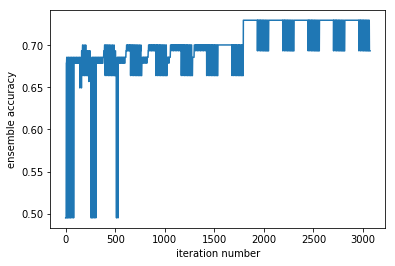

In [134]:
plt.plot(list(range(len(preds_test_ens.values()))), preds_test_ens.values())
plt.xlabel('iteration number')
plt.ylabel('ensemble accuracy')
plt.show()

We can see that max value of the best model = best blending value

So it's the best approch so far. Let's try to change conception and impore catboost's model

## Categorical features selection (wider approach)

In [6]:
features = [
            'fighter_id', 'Wins', 'Losses', 'Draws',
            'Weight Class', 'Stance', 'Odds', 'Opening odds',
            'Month', 'Year', 'Day', 'day_of_week',
            'feature0', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature6.1',
            'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
            'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
            'feature17', 'feature18', 'feature19', 'feature20',
            'feature21', 'feature22', 'feature23', 'feature24', 'feature25',
            'feature26', 'feature27', 'feature28', 'feature29', 'feature30',
            'feature31', 'feature32', 'feature33', 'feature34', 'feature35',
            'feature36', 'feature37', 'feature38', 'feature39', 'feature40',
            'feature41', 'feature42', 'feature43', 'feature44', 'feature45',
            'feature46', 'feature47', 'feature48'
           ]

X_train, X_test, y_train, y_test = split(data[features], result, test_size=0.25, shuffle=True, random_state=42)

In [23]:
for i in enumerate(features):
    print(i[0], i[1])

0 fighter_id 32233.0
1 Wins 19.0
2 Losses 4.0
3 Draws 0.0
4 Weight Class 155.0
5 Stance 3.0
6 Odds -300.0
7 Opening odds -275.0
8 Month 1.0
9 Year 2014.0
10 Day 23.0
11 day_of_week 3.0
12 feature0 16644.0
13 feature1 7.0
14 feature2 1.0
15 feature3 30.0
16 feature4 446.0
17 feature5 65.748
18 feature6 65.3846
19 feature6.1 4.0
20 feature7 6.0
21 feature8 9.0
22 feature9 175.26
23 feature10 1.0
24 feature11 2.7
25 feature12 724.0
26 feature13 0.8
27 feature14 1.04073159928618
28 feature15 63.1249900100223
29 feature16 0.9716738972019452
30 feature17 1.8723
31 feature18 11459.304996
32 feature19 70.0
33 feature20 84.0316
34 feature21 288.2222
35 feature22 13.6383
36 feature23 30.7447
37 feature24 0.8723
38 feature25 1.8723
39 feature26 40.9149
40 feature27 0.4894
41 feature28 0.2766
42 feature29 2.9149
43 feature30 3.1064
44 feature31 0.4468
45 feature32 22.4894
46 feature33 6.4468
47 feature34 3.383
48 feature35 19.3404
49 feature36 4.7872
50 feature37 2.766
51 feature38 1.617
52 featur

Let's filter all features which can be categorical theoretically 

Stance feature should always be categorical

In [48]:
import itertools


cat_possible_combination = []
cat_feat = [0,1,2,3,4,5,8,9,10,11, 23, 21, 20, 19]
for L in range(0, len(cat_feat)+1):
    for subset in itertools.combinations(cat_feat, L):
        cat_possible_combination.append(list(subset))
for i in cat_possible_combination:
    if not 0 in i:
        i.append(0)
    if not 5 in i:
        i.append(5)
cat_possible_combination_new = []
for i in cat_possible_combination:
    if i not in cat_possible_combination_new:
        cat_possible_combination_new.append(i)
cat_possible_combination = cat_possible_combination_new
del cat_possible_combination_new

## Directed cat features appending

In [105]:
%%time

cur_cat_features = [5]
cat_feat = [0,1,2,3,4,8,9,10,11, 23, 21, 20, 19]
cat = CatBoostClassifier(eval_metric='Accuracy',
                         allow_writing_files=False,
                         use_best_model=True)
cat_feature_dict = {}
for new_feature in cat_feat:
    cat.fit(X_train, y_train, eval_set=(X_test, y_test), 
            cat_features=cur_cat_features,
            use_best_model=True, silent=True)
    
    cat_feature_dict[str(cur_cat_features)] = [accuracy_score(cat.predict(X_test), y_test), 
                                                                   accuracy_score(cat.predict(X_train), y_train)]
    print("Current feature list: {}".format(str(cur_cat_features)))
    cur_cat_features.append(new_feature)

Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Wall time: 13min 4s


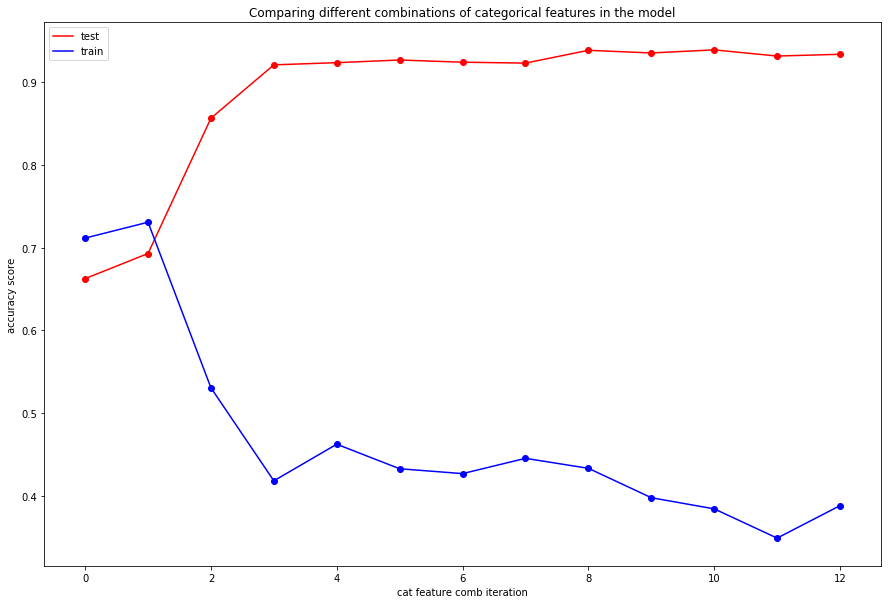

In [106]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 0], color='red', label='test')
ax.plot(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 1], color='blue', label='train')
ax.scatter(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 0], color='red')
ax.scatter(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 1], color='blue')
ax.set_xlabel('cat feature comb iteration')
ax.set_ylabel('accuracy score')
ax.set_title('Comparing different combinations of categorical features in the model')
ax.legend()

We can see a big overfitting if we treat many feature as categorical. Let's try to find the best combinations

## Random cat features appending

In [109]:
%%time
from numpy import random as rand

num_iters = 100
cat = CatBoostClassifier(eval_metric='Accuracy',
                         allow_writing_files=False,
                         use_best_model=True)
cat_feature_dict = {}
for i in range(num_iters):
    random_num = rand.randint(len(cat_possible_combination))
    cat.fit(X_train, y_train, eval_set=(X_test, y_test), 
            cat_features=list(cat_possible_combination[random_num]),
            use_best_model=True, silent=True)
    cat_feature_dict[str(cat_possible_combination[random_num])] = [accuracy_score(cat.predict(X_test), y_test), 
                                                                   accuracy_score(cat.predict(X_train), y_train)]
    print("{} out of {}".format(i, num_iters))

Learning rate set to 0.093544
0 out of 100
Learning rate set to 0.093544
1 out of 100
Learning rate set to 0.093544
2 out of 100
Learning rate set to 0.093544
3 out of 100
Learning rate set to 0.093544
4 out of 100
Learning rate set to 0.093544
5 out of 100
Learning rate set to 0.093544
6 out of 100
Learning rate set to 0.093544
7 out of 100
Learning rate set to 0.093544
8 out of 100
Learning rate set to 0.093544
9 out of 100
Learning rate set to 0.093544
10 out of 100
Learning rate set to 0.093544
11 out of 100
Learning rate set to 0.093544
12 out of 100
Learning rate set to 0.093544
13 out of 100
Learning rate set to 0.093544
14 out of 100
Learning rate set to 0.093544
15 out of 100
Learning rate set to 0.093544
16 out of 100
Learning rate set to 0.093544
17 out of 100
Learning rate set to 0.093544
18 out of 100
Learning rate set to 0.093544
19 out of 100
Learning rate set to 0.093544
20 out of 100
Learning rate set to 0.093544
21 out of 100
Learning rate set to 0.093544
22 out of 10

In [110]:
import operator
sorted(cat_feature_dict.items(), key=operator.itemgetter(1), reverse=True)

[('[0, 1, 2, 4, 8, 9, 10, 23, 21, 19, 5]',
  [0.9365333333333333, 0.42133333333333334]),
 ('[1, 2, 3, 4, 9, 10, 11, 20, 19, 0, 5]',
  [0.9338666666666666, 0.37493333333333334]),
 ('[1, 2, 4, 10, 23, 19, 0, 5]', [0.9322666666666667, 0.44106666666666666]),
 ('[1, 2, 3, 8, 10, 11, 23, 21, 0, 5]', [0.9296, 0.4149333333333333]),
 ('[1, 2, 3, 5, 10, 11, 20, 0]', [0.928, 0.44693333333333335]),
 ('[1, 2, 3, 4, 5, 8, 9, 0]', [0.928, 0.4298666666666667]),
 ('[1, 2, 5, 20, 19, 0]', [0.9274666666666667, 0.4232888888888889]),
 ('[0, 1, 2, 4, 5, 8, 9, 11, 21, 20, 19]',
  [0.9269333333333334, 0.41955555555555557]),
 ('[0, 1, 2, 3, 8, 10, 23, 20, 5]', [0.9253333333333333, 0.4384]),
 ('[1, 2, 3, 4, 5, 23, 21, 19, 0]', [0.9248, 0.4369777777777778]),
 ('[1, 2, 5, 8, 9, 10, 23, 21, 20, 0]', [0.9248, 0.4033777777777778]),
 ('[1, 2, 5, 9, 20, 0]', [0.9242666666666667, 0.43822222222222224]),
 ('[0, 1, 2, 4, 8, 11, 20, 19, 5]', [0.9226666666666666, 0.44693333333333335]),
 ('[0, 1, 2, 5, 10, 20]', [0.922666666

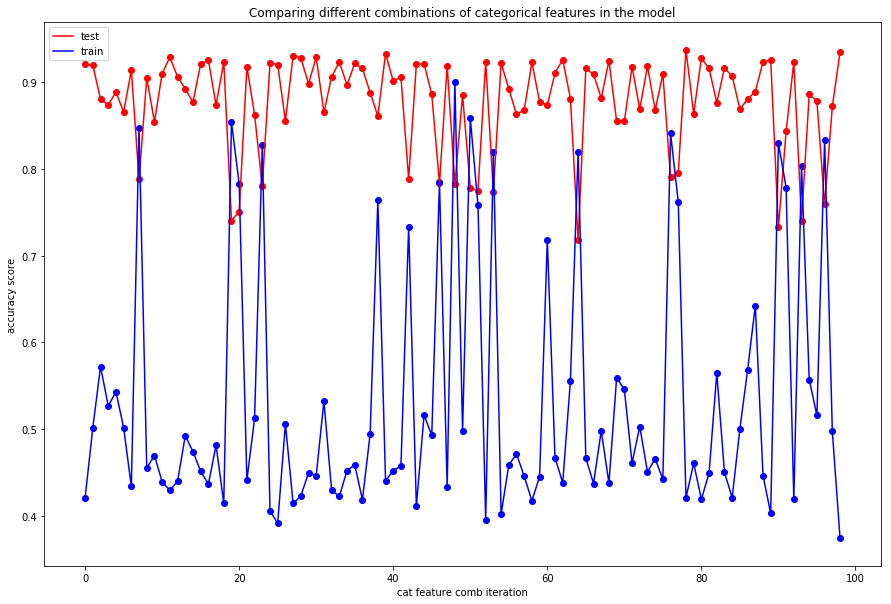

In [111]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 0], color='red', label='test')
ax.plot(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 1], color='blue', label='train')
ax.scatter(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 0], color='red')
ax.scatter(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 1], color='blue')
ax.set_xlabel('cat feature comb iteration')
ax.set_ylabel('accuracy score')
ax.set_title('Comparing different combinations of categorical features in the model')
ax.legend()

We can see a strong overfitting. Let's see only valid values (train acc > test acc)

In [113]:
for key, value in cat_feature_dict.items():
    if value[1] >= value[0]:
        print(key, value)

[0, 3, 5, 8, 9, 10, 21, 20] [0.7877333333333333, 0.8464]
[8, 9, 10, 0, 5] [0.7402666666666666, 0.8531555555555556]
[4, 5, 11, 23, 21, 0] [0.7504, 0.7822222222222223]
[4, 8, 9, 23, 21, 20, 0, 5] [0.7797333333333333, 0.8272]
[3, 5, 8, 9, 10, 11, 21, 20, 0] [0.7829333333333334, 0.7843555555555556]
[4, 5, 9, 23, 21, 20, 0] [0.7824, 0.8999111111111111]
[3, 5, 9, 10, 11, 23, 21, 0] [0.7781333333333333, 0.8577777777777778]
[0, 3, 8, 9, 10, 11, 21, 5] [0.7728, 0.8192]
[4, 10, 19, 0, 5] [0.7173333333333334, 0.8195555555555556]
[0, 8, 9, 10, 11, 23, 21, 5] [0.7898666666666667, 0.8405333333333334]
[0, 3, 4, 8, 11, 20, 19, 5] [0.7322666666666666, 0.8291555555555555]
[3, 5, 8, 9, 21, 0] [0.7402666666666666, 0.8030222222222222]
[0, 5, 9, 11, 23, 20, 19] [0.7589333333333333, 0.8330666666666666]


In [114]:
cat.fit(X_train, y_train, eval_set=(X_test, y_test), 
            cat_features=[0, 3, 5, 10, 11, 21, 19],
            use_best_model=True)

Learning rate set to 0.093544
0:	learn: 0.6501333	test: 0.6357333	best: 0.6357333 (0)	total: 36ms	remaining: 36s
1:	learn: 0.6620444	test: 0.6565333	best: 0.6565333 (1)	total: 91.6ms	remaining: 45.7s
2:	learn: 0.6650667	test: 0.6528000	best: 0.6565333 (1)	total: 115ms	remaining: 38.2s
3:	learn: 0.6720000	test: 0.6544000	best: 0.6565333 (1)	total: 179ms	remaining: 44.5s
4:	learn: 0.6682667	test: 0.6554667	best: 0.6565333 (1)	total: 242ms	remaining: 48.1s
5:	learn: 0.6691556	test: 0.6533333	best: 0.6565333 (1)	total: 294ms	remaining: 48.7s
6:	learn: 0.6679111	test: 0.6538667	best: 0.6565333 (1)	total: 348ms	remaining: 49.4s
7:	learn: 0.6696889	test: 0.6608000	best: 0.6608000 (7)	total: 409ms	remaining: 50.7s
8:	learn: 0.6846222	test: 0.6768000	best: 0.6768000 (8)	total: 473ms	remaining: 52.1s
9:	learn: 0.7004444	test: 0.6901333	best: 0.6901333 (9)	total: 528ms	remaining: 52.3s
10:	learn: 0.7088000	test: 0.6912000	best: 0.6912000 (10)	total: 582ms	remaining: 52.3s
11:	learn: 0.7226667	tes

97:	learn: 0.8202667	test: 0.7690667	best: 0.7701333 (96)	total: 5.75s	remaining: 52.9s
98:	learn: 0.8204444	test: 0.7706667	best: 0.7706667 (98)	total: 5.81s	remaining: 52.9s
99:	learn: 0.8211556	test: 0.7696000	best: 0.7706667 (98)	total: 5.87s	remaining: 52.8s
100:	learn: 0.8215111	test: 0.7696000	best: 0.7706667 (98)	total: 5.92s	remaining: 52.7s
101:	learn: 0.8222222	test: 0.7712000	best: 0.7712000 (101)	total: 5.99s	remaining: 52.8s
102:	learn: 0.8229333	test: 0.7717333	best: 0.7717333 (102)	total: 6.06s	remaining: 52.7s
103:	learn: 0.8234667	test: 0.7738667	best: 0.7738667 (103)	total: 6.11s	remaining: 52.6s
104:	learn: 0.8234667	test: 0.7722667	best: 0.7738667 (103)	total: 6.16s	remaining: 52.5s
105:	learn: 0.8240000	test: 0.7728000	best: 0.7738667 (103)	total: 6.22s	remaining: 52.5s
106:	learn: 0.8248889	test: 0.7712000	best: 0.7738667 (103)	total: 6.3s	remaining: 52.6s
107:	learn: 0.8256000	test: 0.7722667	best: 0.7738667 (103)	total: 6.37s	remaining: 52.6s
108:	learn: 0.8257

190:	learn: 0.8718222	test: 0.7770667	best: 0.7829333 (131)	total: 11.3s	remaining: 47.9s
191:	learn: 0.8723556	test: 0.7792000	best: 0.7829333 (131)	total: 11.4s	remaining: 47.8s
192:	learn: 0.8734222	test: 0.7770667	best: 0.7829333 (131)	total: 11.4s	remaining: 47.7s
193:	learn: 0.8721778	test: 0.7781333	best: 0.7829333 (131)	total: 11.5s	remaining: 47.7s
194:	learn: 0.8732444	test: 0.7781333	best: 0.7829333 (131)	total: 11.5s	remaining: 47.6s
195:	learn: 0.8736000	test: 0.7781333	best: 0.7829333 (131)	total: 11.6s	remaining: 47.6s
196:	learn: 0.8730667	test: 0.7760000	best: 0.7829333 (131)	total: 11.7s	remaining: 47.5s
197:	learn: 0.8739556	test: 0.7749333	best: 0.7829333 (131)	total: 11.7s	remaining: 47.4s
198:	learn: 0.8732444	test: 0.7765333	best: 0.7829333 (131)	total: 11.8s	remaining: 47.4s
199:	learn: 0.8734222	test: 0.7765333	best: 0.7829333 (131)	total: 11.8s	remaining: 47.3s
200:	learn: 0.8739556	test: 0.7765333	best: 0.7829333 (131)	total: 11.9s	remaining: 47.2s
201:	learn

285:	learn: 0.9025778	test: 0.7749333	best: 0.7829333 (131)	total: 16.8s	remaining: 42s
286:	learn: 0.9027556	test: 0.7760000	best: 0.7829333 (131)	total: 16.9s	remaining: 42s
287:	learn: 0.9029333	test: 0.7744000	best: 0.7829333 (131)	total: 16.9s	remaining: 41.9s
288:	learn: 0.9031111	test: 0.7749333	best: 0.7829333 (131)	total: 17s	remaining: 41.8s
289:	learn: 0.9036444	test: 0.7760000	best: 0.7829333 (131)	total: 17.1s	remaining: 41.8s
290:	learn: 0.9032889	test: 0.7754667	best: 0.7829333 (131)	total: 17.1s	remaining: 41.7s
291:	learn: 0.9043556	test: 0.7744000	best: 0.7829333 (131)	total: 17.2s	remaining: 41.6s
292:	learn: 0.9043556	test: 0.7749333	best: 0.7829333 (131)	total: 17.2s	remaining: 41.6s
293:	learn: 0.9041778	test: 0.7749333	best: 0.7829333 (131)	total: 17.3s	remaining: 41.5s
294:	learn: 0.9056000	test: 0.7733333	best: 0.7829333 (131)	total: 17.4s	remaining: 41.5s
295:	learn: 0.9066667	test: 0.7733333	best: 0.7829333 (131)	total: 17.4s	remaining: 41.4s
296:	learn: 0.90

377:	learn: 0.9262222	test: 0.7722667	best: 0.7829333 (131)	total: 22.2s	remaining: 36.5s
378:	learn: 0.9260444	test: 0.7722667	best: 0.7829333 (131)	total: 22.2s	remaining: 36.4s
379:	learn: 0.9276444	test: 0.7712000	best: 0.7829333 (131)	total: 22.3s	remaining: 36.4s
380:	learn: 0.9274667	test: 0.7712000	best: 0.7829333 (131)	total: 22.3s	remaining: 36.3s
381:	learn: 0.9272889	test: 0.7722667	best: 0.7829333 (131)	total: 22.4s	remaining: 36.3s
382:	learn: 0.9276444	test: 0.7728000	best: 0.7829333 (131)	total: 22.5s	remaining: 36.2s
383:	learn: 0.9276444	test: 0.7717333	best: 0.7829333 (131)	total: 22.5s	remaining: 36.1s
384:	learn: 0.9265778	test: 0.7722667	best: 0.7829333 (131)	total: 22.6s	remaining: 36s
385:	learn: 0.9280000	test: 0.7717333	best: 0.7829333 (131)	total: 22.6s	remaining: 36s
386:	learn: 0.9278222	test: 0.7722667	best: 0.7829333 (131)	total: 22.7s	remaining: 35.9s
387:	learn: 0.9281778	test: 0.7728000	best: 0.7829333 (131)	total: 22.7s	remaining: 35.9s
388:	learn: 0.

469:	learn: 0.9450667	test: 0.7717333	best: 0.7829333 (131)	total: 27.5s	remaining: 31s
470:	learn: 0.9448889	test: 0.7717333	best: 0.7829333 (131)	total: 27.5s	remaining: 30.9s
471:	learn: 0.9459556	test: 0.7722667	best: 0.7829333 (131)	total: 27.6s	remaining: 30.9s
472:	learn: 0.9461333	test: 0.7733333	best: 0.7829333 (131)	total: 27.7s	remaining: 30.8s
473:	learn: 0.9461333	test: 0.7738667	best: 0.7829333 (131)	total: 27.7s	remaining: 30.8s
474:	learn: 0.9459556	test: 0.7733333	best: 0.7829333 (131)	total: 27.8s	remaining: 30.7s
475:	learn: 0.9468444	test: 0.7733333	best: 0.7829333 (131)	total: 27.8s	remaining: 30.6s
476:	learn: 0.9470222	test: 0.7728000	best: 0.7829333 (131)	total: 27.9s	remaining: 30.6s
477:	learn: 0.9480889	test: 0.7733333	best: 0.7829333 (131)	total: 28s	remaining: 30.5s
478:	learn: 0.9484444	test: 0.7728000	best: 0.7829333 (131)	total: 28s	remaining: 30.5s
479:	learn: 0.9479111	test: 0.7722667	best: 0.7829333 (131)	total: 28.1s	remaining: 30.4s
480:	learn: 0.94

561:	learn: 0.9573333	test: 0.7712000	best: 0.7829333 (131)	total: 32.8s	remaining: 25.6s
562:	learn: 0.9575111	test: 0.7706667	best: 0.7829333 (131)	total: 32.9s	remaining: 25.5s
563:	learn: 0.9576889	test: 0.7701333	best: 0.7829333 (131)	total: 32.9s	remaining: 25.5s
564:	learn: 0.9582222	test: 0.7685333	best: 0.7829333 (131)	total: 33s	remaining: 25.4s
565:	learn: 0.9587556	test: 0.7680000	best: 0.7829333 (131)	total: 33s	remaining: 25.3s
566:	learn: 0.9587556	test: 0.7690667	best: 0.7829333 (131)	total: 33.1s	remaining: 25.3s
567:	learn: 0.9591111	test: 0.7696000	best: 0.7829333 (131)	total: 33.2s	remaining: 25.2s
568:	learn: 0.9591111	test: 0.7690667	best: 0.7829333 (131)	total: 33.2s	remaining: 25.2s
569:	learn: 0.9594667	test: 0.7701333	best: 0.7829333 (131)	total: 33.3s	remaining: 25.1s
570:	learn: 0.9596444	test: 0.7706667	best: 0.7829333 (131)	total: 33.4s	remaining: 25.1s
571:	learn: 0.9592889	test: 0.7701333	best: 0.7829333 (131)	total: 33.4s	remaining: 25s
572:	learn: 0.95

653:	learn: 0.9662222	test: 0.7717333	best: 0.7829333 (131)	total: 38.1s	remaining: 20.2s
654:	learn: 0.9665778	test: 0.7701333	best: 0.7829333 (131)	total: 38.2s	remaining: 20.1s
655:	learn: 0.9671111	test: 0.7712000	best: 0.7829333 (131)	total: 38.3s	remaining: 20.1s
656:	learn: 0.9669333	test: 0.7712000	best: 0.7829333 (131)	total: 38.3s	remaining: 20s
657:	learn: 0.9667556	test: 0.7712000	best: 0.7829333 (131)	total: 38.4s	remaining: 19.9s
658:	learn: 0.9667556	test: 0.7712000	best: 0.7829333 (131)	total: 38.4s	remaining: 19.9s
659:	learn: 0.9669333	test: 0.7685333	best: 0.7829333 (131)	total: 38.5s	remaining: 19.8s
660:	learn: 0.9669333	test: 0.7696000	best: 0.7829333 (131)	total: 38.5s	remaining: 19.8s
661:	learn: 0.9669333	test: 0.7685333	best: 0.7829333 (131)	total: 38.6s	remaining: 19.7s
662:	learn: 0.9669333	test: 0.7690667	best: 0.7829333 (131)	total: 38.7s	remaining: 19.6s
663:	learn: 0.9674667	test: 0.7685333	best: 0.7829333 (131)	total: 38.7s	remaining: 19.6s
664:	learn: 

745:	learn: 0.9740444	test: 0.7658667	best: 0.7829333 (131)	total: 43.4s	remaining: 14.8s
746:	learn: 0.9742222	test: 0.7658667	best: 0.7829333 (131)	total: 43.5s	remaining: 14.7s
747:	learn: 0.9742222	test: 0.7653333	best: 0.7829333 (131)	total: 43.6s	remaining: 14.7s
748:	learn: 0.9740444	test: 0.7648000	best: 0.7829333 (131)	total: 43.6s	remaining: 14.6s
749:	learn: 0.9740444	test: 0.7653333	best: 0.7829333 (131)	total: 43.7s	remaining: 14.6s
750:	learn: 0.9740444	test: 0.7664000	best: 0.7829333 (131)	total: 43.7s	remaining: 14.5s
751:	learn: 0.9740444	test: 0.7664000	best: 0.7829333 (131)	total: 43.8s	remaining: 14.4s
752:	learn: 0.9736889	test: 0.7664000	best: 0.7829333 (131)	total: 43.8s	remaining: 14.4s
753:	learn: 0.9742222	test: 0.7664000	best: 0.7829333 (131)	total: 43.9s	remaining: 14.3s
754:	learn: 0.9742222	test: 0.7669333	best: 0.7829333 (131)	total: 44s	remaining: 14.3s
755:	learn: 0.9744000	test: 0.7669333	best: 0.7829333 (131)	total: 44s	remaining: 14.2s
756:	learn: 0.

837:	learn: 0.9779556	test: 0.7632000	best: 0.7829333 (131)	total: 48.8s	remaining: 9.42s
838:	learn: 0.9781333	test: 0.7632000	best: 0.7829333 (131)	total: 48.8s	remaining: 9.37s
839:	learn: 0.9779556	test: 0.7632000	best: 0.7829333 (131)	total: 48.9s	remaining: 9.31s
840:	learn: 0.9779556	test: 0.7626667	best: 0.7829333 (131)	total: 48.9s	remaining: 9.25s
841:	learn: 0.9779556	test: 0.7632000	best: 0.7829333 (131)	total: 49s	remaining: 9.19s
842:	learn: 0.9781333	test: 0.7610667	best: 0.7829333 (131)	total: 49s	remaining: 9.13s
843:	learn: 0.9784889	test: 0.7616000	best: 0.7829333 (131)	total: 49.1s	remaining: 9.07s
844:	learn: 0.9783111	test: 0.7621333	best: 0.7829333 (131)	total: 49.1s	remaining: 9.02s
845:	learn: 0.9783111	test: 0.7626667	best: 0.7829333 (131)	total: 49.2s	remaining: 8.96s
846:	learn: 0.9783111	test: 0.7626667	best: 0.7829333 (131)	total: 49.3s	remaining: 8.9s
847:	learn: 0.9783111	test: 0.7626667	best: 0.7829333 (131)	total: 49.3s	remaining: 8.84s
848:	learn: 0.9

929:	learn: 0.9843556	test: 0.7648000	best: 0.7829333 (131)	total: 54.1s	remaining: 4.07s
930:	learn: 0.9847111	test: 0.7658667	best: 0.7829333 (131)	total: 54.1s	remaining: 4.01s
931:	learn: 0.9848889	test: 0.7653333	best: 0.7829333 (131)	total: 54.2s	remaining: 3.95s
932:	learn: 0.9850667	test: 0.7664000	best: 0.7829333 (131)	total: 54.2s	remaining: 3.89s
933:	learn: 0.9848889	test: 0.7664000	best: 0.7829333 (131)	total: 54.3s	remaining: 3.84s
934:	learn: 0.9852444	test: 0.7674667	best: 0.7829333 (131)	total: 54.3s	remaining: 3.78s
935:	learn: 0.9852444	test: 0.7674667	best: 0.7829333 (131)	total: 54.4s	remaining: 3.72s
936:	learn: 0.9850667	test: 0.7674667	best: 0.7829333 (131)	total: 54.5s	remaining: 3.66s
937:	learn: 0.9852444	test: 0.7674667	best: 0.7829333 (131)	total: 54.5s	remaining: 3.6s
938:	learn: 0.9850667	test: 0.7669333	best: 0.7829333 (131)	total: 54.6s	remaining: 3.54s
939:	learn: 0.9850667	test: 0.7669333	best: 0.7829333 (131)	total: 54.6s	remaining: 3.49s
940:	learn:

In [115]:
print(accuracy_score(cat.predict(X_test), y_test))
print(accuracy_score(cat.predict(X_train), y_train))

0.7829333333333334
0.8060444444444445


We can see that results with 0.9+ test accuracy are completely overfitted on test data

###  Our best result so far is:

#### test: 0.7915

#### train: 0.827